# Food Vision Classifier

The purpose of this project is to explore computer vision by analyzing the food-101 dataset. Ultimately, the final outcome of this project is to outperform the model built and trained in the DeepFood paper (see link below), at peak performance of 77.4% accuracy when running on the same test dataset used in this notebook.

* https://arxiv.org/pdf/1606.05675.pdf

The starting point will consist of using the EfficientNetB0 model as a baseline, and fine-tune and improve upon each model to outperform the DeepFood paper.

**NOTE** This notebook was built using google colab. Certain functionality may not be needed if using a jupyter notebook directly.

## Check GPU

Google Colab offers free GPU's, however, not all of them are compatible with mixed precision training.

Models Include:
* K80 (Not Compatible)
* P100 (Not Compatible)
* Tesla T4 (Compatible)

Knowing this, in order to use mixed precision training, we need access to a Tesla T4 from within Google Colab. If we are using our own hardware, the GPU needs a score of 7.0+.

## Setup

In [ ]:
# Setting up the notebook with a GPU
# NOTE: We need a Tesla T4 in ourder to use mixed precision training
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Make the corresponding directories
!mkdir logs
!mkdir logs/history
!mkdir logs/tensorboard
!mkdir checkpoints

In [ ]:
# Retrieving all the helper files from github
!wget -P src https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/__init__.py
!wget -P src/utils https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/utils/__init__.py
!wget -P src/utils https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/utils/callbacks.py
!wget -P src/utils https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/utils/image.py
!wget -P src/utils https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/utils/learning_rate.py
!wget -P src/utils https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/utils/plot.py
!wget -P src/utils https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/utils/preprocessing.py
!wget -P src/utils https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/utils/visualize.py

--2023-08-24 20:47:09--  https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 0 [text/plain]
Saving to: ‘src/__init__.py’

__init__.py             [ <=>                ]       0  --.-KB/s    in 0s      

2023-08-24 20:47:10 (0.00 B/s) - ‘src/__init__.py’ saved [0/0]

--2023-08-24 20:47:10--  https://raw.githubusercontent.com/bkubick/deep-learning-development/main/src/utils/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233 [text/plain]

## Imports

In [ ]:
import os
import pathlib
import random
import sys
from typing import Tuple

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_hub as hub

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import utils

## Additional Helper Functions

In [ ]:
def summarize_model_layer_parameters(model: tf.keras.models.Model) -> None:
  """ Helper function to print out certain parameter values for each layer in a
      given model. Parameters it prints are:

      - layer.name
      - layer.trainable
      - layer.dtype
      - layer.dtype_policy

      Args:
        model (tf.keras.models.Model): The model of which to summarize the layers.
  """
  for layer in model.layers:
    print(f'{layer.name} trainable={layer.trainable} dtype={layer.dtype} dtype_policy={layer.dtype_policy}')

## Getting Data Using TensorFlow Datasets (TFDS)



In [ ]:
# Load in the food-101 dataset from tfds (NOTE: this can take about 5-6 minutes to fully load in google colab)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,  # Return type is tuple of (data, label)
                                             with_info=True)

## Exploring Food-101 Data from TFDS

To better visualize the Food-101 data, there are some things we want to look at:

* Class names
* The shape of our input data
* The datatype of our input data
* The labels (e.g. are they one hot encoded, label encoded, etc)
* Do the labels match with the class names

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10], len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)

In [ ]:
# Lets look at one sample of the training data
train_data_sample = train_data.take(1)
train_data_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about training sample
for image, label in train_data_sample:
  print(f"""
    Image Shape: {image.shape}
    Image DataType: {image.dtype}
    Target Class from Food-101 (tensor form): {label}
    Class Name: {class_names[label.numpy()]}
  """)


    Image Shape: (512, 512, 3)
    Image DataType: <dtype: 'uint8'>
    Target Class from Food-101 (tensor form): 65
    Class Name: mussels
  


In [ ]:
# What does the image tensor look like?
tf.reduce_min(image), tf.reduce_max(image), image.dtype

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 tf.uint8)

(-0.5, 511.5, 511.5, -0.5)

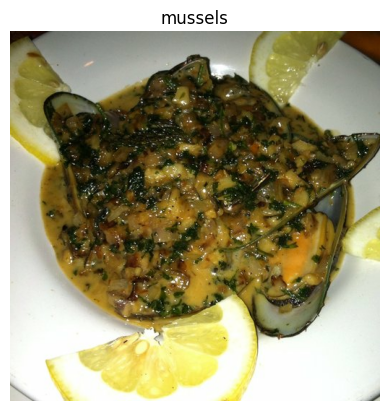

In [ ]:
# What does the image look like
plt.figure()
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Setting Constants

In [ ]:
img_size = 224
input_shape = (img_size, img_size, 3)

## Preprocessing Data

Neural networks perform best when data is structured in a certain way (e.g. batched, normalized, etc.). Not all data, including from tensorflow datasets, comes structured nicel. In order to properly utilize a Neural Network, the data needs to be preprocessed to cleanup and erstructure our data.

Findings from looking at our data:
* Data is in uint8 datatype
* Data is composed of different sized images
* Data is not normalized (e.g. pixels between 0-255 instead of 0-1)

What Structure Models Perform Best With:
* Data in float32 (or for mixed precision, float16 and float32)
* For batches, all the tensors within batch are of the same size
* Pixels scaled (between 0 & 1) generally perform better.

With this in mind, there are a few things I need to do to get the data structured properly. Since I am going to be using an EfficientNetBX base trained model, the scaling will be taken care of for me because it is already built into the model.

In [ ]:
preprocess_image = utils.preprocessing.generate_preprocess_image_function(img_shape=img_size)

In [ ]:
# Lets test this out
preprocessed_image, preprocessed_label = preprocess_image(image, label)
preprocessed_image.shape, preprocessed_image.dtype

(TensorShape([224, 224, 3]), tf.float32)

## Batch and Prepare Datasets

Creating performant data pipelines with tensorflow. I need to make this pipeline run fast. For more resources on how to do this, read the following docs:

* https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training data, and parallelize it
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the train_data and turn into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data, and parallelize it
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test_data into batches
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify that the shape changed, dtype change, and the dataset is a PrefetchDataset
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Setup Mixed Precision Training

For a deeper understanding of mixed precision training, checkout the TensorFlow guide:

* https://www.tensorflow.org/guide/mixed_precision

Mixed precision utlizes a combination of float16 and float32 datatypes to speed up training.

In [ ]:
# Turn on mixed precision training (only works if compatible GPU)
tf.keras.mixed_precision.set_global_policy('mixed_float16') # sets the mixed precision policy to float16
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

## Creating Model Callback Paths

There are going to be a few callbacks I am going to setup.

* History CSV Callback
* Best Weights Callback
* Last Epoch Weights Callback
* TensorBoard Callback

In [ ]:
# Setting up the base path directories for the callbacks
checkpoint_base_path = 'checkpoints'
csv_base_path = 'logs/history'
tensorboard_base_path = 'logs/tensorboard'

## Baseline Feature Extraction Model

The first model (`model_0`) is going to be the baseline model on which to analyze each model against. The purpose of this is to determine whether each model improved following the fine tuned adjustments made.

In [ ]:
# If model_0 has already been built, it will exist in the following path
model_0_path = 'models/model_0'

In [ ]:
# 1. Create base model from EfficientNetB0
base_model_0 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_0.trainable = False

# 2. Create functional model
input_layer = layers.Input(shape=input_shape, name='InputLayer')

# Note: EfficientNetBX models have scaling built into the model
x = base_model_0(input_layer, training=False)

# 3. Global Average Pooling Layer
x = layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)

# 4. Output Layer (splitting the activation as a separate function to specify the dtype)
x = layers.Dense(len(class_names))(x)
output_layer = layers.Activation('softmax', dtype=tf.float32, name='SoftmaxOutputLayer')(x)

# Creating model
model_0 = tf.keras.models.Model(input_layer, output_layer)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# Compile Model
model_0.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Lets get some summaries of the model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePoolingLayer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 SoftmaxOutputLayer (Activat  (None, 101)              0         
 ion)                                                            
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

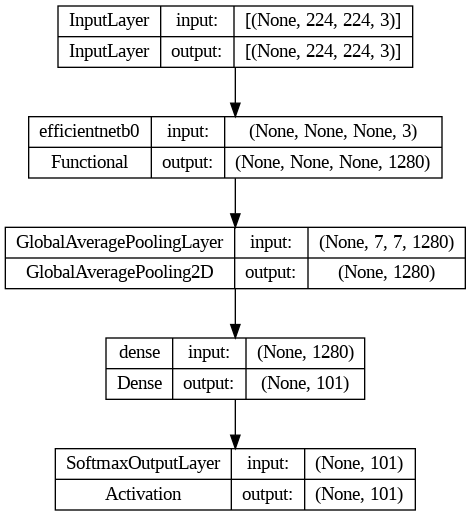

In [ ]:
utils.visualize.visualize_model(model_0)

In [ ]:
# Lets look at the datatype of each layer to tell if we are using mixed precision
summarize_model_layer_parameters(model_0)

InputLayer trainable=True dtype=float32 dtype_policy=<Policy "float32">
efficientnetb0 trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
GlobalAveragePoolingLayer trainable=True dtype=float32 dtype_policy=<Policy "mixed_float16">
dense trainable=True dtype=float32 dtype_policy=<Policy "mixed_float16">
SoftmaxOutputLayer trainable=True dtype=float32 dtype_policy=<Policy "float32">


In [ ]:
# Lets look at the datatype of each layer of the base_model to tell if we are using mixed precision
summarize_model_layer_parameters(base_model_0)

input_1 trainable=False dtype=float32 dtype_policy=<Policy "float32">
rescaling trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
normalization trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
rescaling_1 trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_conv_pad trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_conv trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_bn trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_activation trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_dwconv trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_bn trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_activation trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_se_squeeze trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_se_reshape trainable=False

In [ ]:
# Checkpoint names
checkpoint_best_weights_model_0 = f'{checkpoint_base_path}/model_0/best_weights/checkpoint.ckpt'
checkpoint_last_weights_model_0 = f'{checkpoint_base_path}/model_0/last_weights/checkpoint.ckpt'

In [ ]:
# Fit the model
model_0.fit(train_data,
            epochs=3,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(len(test_data) * 0.15),
            callbacks=[
                utils.callbacks.generate_checkpoint_callback(checkpoint_best_weights_model_0, best_only=True),
                utils.callbacks.generate_checkpoint_callback(checkpoint_last_weights_model_0, best_only=False),
                utils.callbacks.generate_tensorboard_callback(tensorboard_base_path, 'model_0'),
                utils.callbacks.generate_csv_logger_callback('model_0_history.csv', csv_base_path),
            ])

Saving TensorBoard log files to:  logs/tensorboard/model_0/20230824-181919
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7156 - accuracy: 0.5839
Epoch 1: val_accuracy improved from -inf to 0.69942, saving model to checkpoints/model_0/best_weights/checkpoint.ckpt

Epoch 1: saving model to checkpoints/model_0/last_weights/checkpoint.ckpt
2368/2368 [==============================] - 219s 84ms/step - loss: 1.7156 - accuracy: 0.5839 - val_loss: 1.1193 - val_accuracy: 0.6994
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1996 - accuracy: 0.6884
Epoch 2: val_accuracy improved from 0.69942 to 0.71875, saving model to checkpoints/model_0/best_weights/checkpoint.ckpt

Epoch 2: saving model to checkpoints/model_0/last_weights/checkpoint.ckpt
2368/2368 [==============================] - 203s 84ms/step - loss: 1.1996 - accuracy: 0.6884 - val_loss: 1.0330 - val_accuracy: 0.7188
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss:

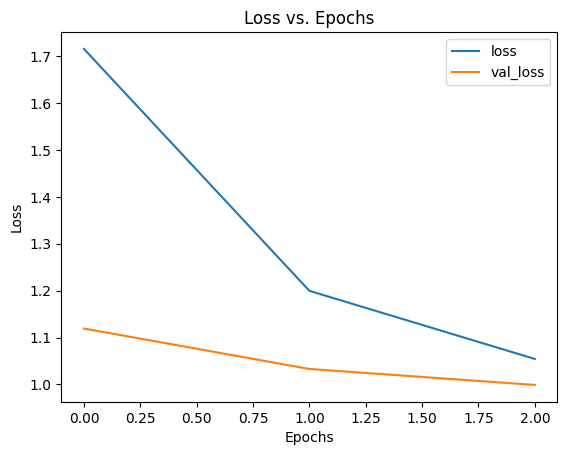

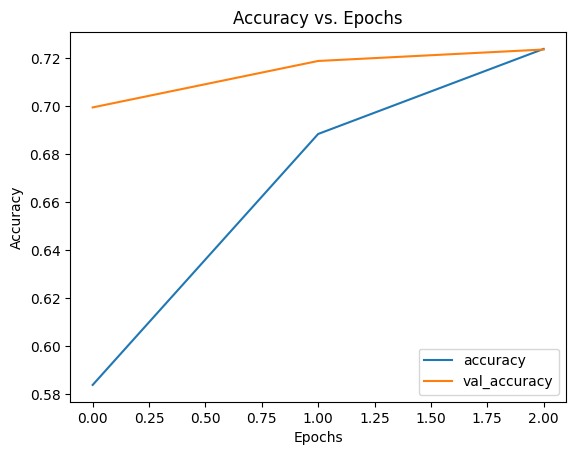

In [ ]:
# Lets look at the data
# Saved the history, so going to load in the history from the csv it was saved to
history_0_loaded = pd.read_csv(f'{csv_base_path}/model_0_history.csv', index_col='epoch')

utils.plot.plot_history(history_0_loaded, metric='loss')
utils.plot.plot_history(history_0_loaded, metric='accuracy')

In [ ]:
model_0_performance = model_0.evaluate(test_data)
model_0_performance

790/790 [==============================] - 59s 74ms/step - loss: 0.9980 - accuracy: 0.7296


[0.9979621767997742, 0.7296237349510193]

In [ ]:
# Saving the model
# NOTE: the below code is resulting in the following ERROR
# TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
# model_0.save(model_0_path)

### Model 1: Fine Tuning

The first model to look at will introduce fine tuning into the previous model. This will allow adjusting and tuning parameters from the transfer learning base model to better adjust our model.

For this model, I will only allow the last 40 layers in the base model to be trainable, and all other layers will remain unchanged.

In [ ]:
# 2-3. Starting from model_0 (Reloading in where model_0 left off from)
model_1 = tf.keras.models.clone_model(model_0)
model_1.load_weights(checkpoint_last_weights_model_0)

# Setting the efficient net model to be trainable
base_model_1 = model_1.layers[1]
base_model_1.trainable = True

# Setting all but last 40 layers in base_model to be not traininable (only last 5 layers are trainable)
for layer in base_model_1.layers[:-40]:
    layer.trainable = False

In [ ]:
# Recompiling the fine tuned model
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePoolingLayer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 SoftmaxOutputLayer (Activat  (None, 101)              0         
 ion)                                                            
                                                                 
Total params: 4,178,952
Trainable params: 2,180,085
Non-train

In [ ]:
# Lets look at the datatype of each layer of the base_model to tell if we are using mixed precision
summarize_model_layer_parameters(base_model_1)

input_1 trainable=False dtype=float32 dtype_policy=<Policy "float32">
rescaling trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
normalization trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
rescaling_1 trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_conv_pad trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_conv trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_bn trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_activation trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_dwconv trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_bn trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_activation trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_se_squeeze trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_se_reshape trainable=False

In [ ]:
# Checkpoint names
checkpoint_best_weights_model_1 = f'{checkpoint_base_path}/model_1/best_weights/checkpoint.ckpt'
checkpoint_last_weights_model_1 = f'{checkpoint_base_path}/model_1/last_weights/checkpoint.ckpt'

In [ ]:
# Setting up Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# Fit the model
model_1.fit(train_data,
            epochs=100,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(len(test_data) * 0.15),
            callbacks=[
                utils.callbacks.generate_checkpoint_callback(checkpoint_best_weights_model_1, best_only=True),
                utils.callbacks.generate_checkpoint_callback(checkpoint_last_weights_model_1, best_only=False),
                utils.callbacks.generate_tensorboard_callback(tensorboard_base_path, 'model_1'),
                utils.callbacks.generate_csv_logger_callback('model_1_history.csv', csv_base_path),
                early_stopping_callback,
            ])

Saving TensorBoard log files to:  logs/tensorboard/model_1/20230824-183455
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.5572 - accuracy: 0.6045
Epoch 1: val_accuracy improved from -inf to 0.71901, saving model to checkpoints/model_1/best_weights/checkpoint.ckpt

Epoch 1: saving model to checkpoints/model_1/last_weights/checkpoint.ckpt
2368/2368 [==============================] - 230s 88ms/step - loss: 1.5572 - accuracy: 0.6045 - val_loss: 1.0540 - val_accuracy: 0.7190
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9960 - accuracy: 0.7317
Epoch 2: val_accuracy improved from 0.71901 to 0.73755, saving model to checkpoints/model_1/best_weights/checkpoint.ckpt

Epoch 2: saving model to checkpoints/model_1/last_weights/checkpoint.ckpt
2368/2368 [==============================] - 209s 87ms/step - loss: 0.9962 - accuracy: 0.7317 - val_loss: 0.9717 - val_accuracy: 0.7376
Epoch 3/100
2368/2368 [==============================] - ETA: 0s -

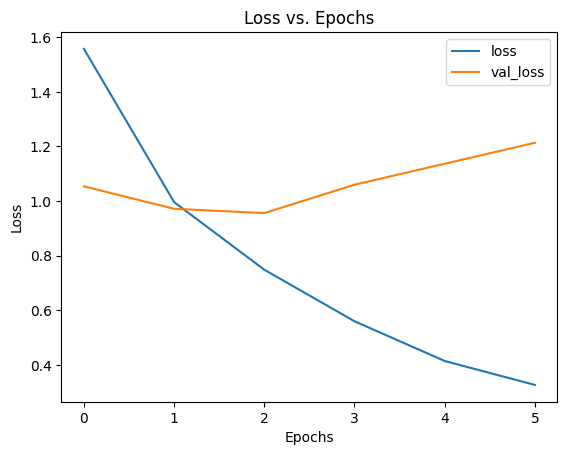

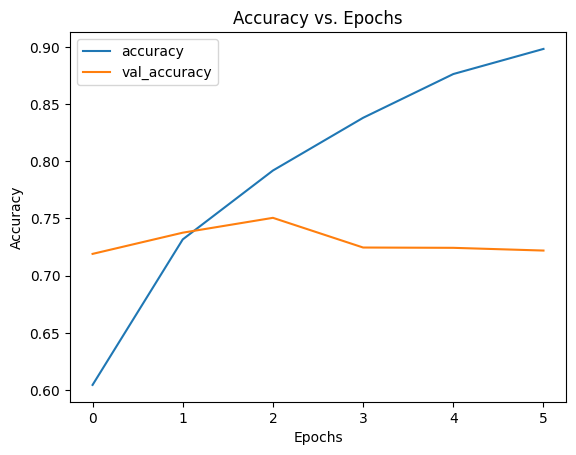

In [ ]:
# Lets look at the data
# Saved the history, so going to load in the history from the csv it was saved to
history_1_loaded = pd.read_csv(f'{csv_base_path}/model_1_history.csv', index_col='epoch')

utils.plot.plot_history(history_1_loaded, metric='loss')
utils.plot.plot_history(history_1_loaded, metric='accuracy')

In [ ]:
model_1_performance = model_1.evaluate(test_data)
model_1_performance

790/790 [==============================] - 64s 81ms/step - loss: 0.9501 - accuracy: 0.7458


[0.9501062035560608, 0.745782196521759]

### Model 2: Fine Tuning

The second model to look at will introduce fine tuning into the previous model. This will allow adjusting and tuning parameters from the transfer learning base model to better adjust our model.

For this model, I will allow all layers from the base model to be trainable.

In [ ]:
# 2-3. Starting from model_0 (Reloading in where model_0 left off from)
model_2 = tf.keras.models.clone_model(model_0)
model_2.load_weights(checkpoint_last_weights_model_0)

# Setting the efficient net model to be trainable
base_model_2 = model_2.layers[1]
base_model_2.trainable = True

for layer in base_model_2.layers[:-20]:
  layer.trainable = False

In [ ]:
# Recompiling the fine tuned model
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePoolingLayer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 SoftmaxOutputLayer (Activat  (None, 101)              0         
 ion)                                                            
                                                                 
Total params: 4,178,952
Trainable params: 1,480,341
Non-train

In [ ]:
# Checkpoint names
checkpoint_best_weights_model_2 = f'{checkpoint_base_path}/model_2/best_weights/checkpoint.ckpt'
checkpoint_last_weights_model_2 = f'{checkpoint_base_path}/model_2/last_weights/checkpoint.ckpt'

In [ ]:
# Setting up Early Stopping Callback
early_stopping_callback_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# Fit the model
model_2.fit(train_data,
            epochs=100,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(len(test_data) * 0.15),
            callbacks=[
                utils.callbacks.generate_checkpoint_callback(checkpoint_best_weights_model_2, best_only=True),
                utils.callbacks.generate_checkpoint_callback(checkpoint_last_weights_model_2, best_only=False),
                utils.callbacks.generate_tensorboard_callback(tensorboard_base_path, 'model_2'),
                utils.callbacks.generate_csv_logger_callback('model_2_history.csv', csv_base_path),
                early_stopping_callback_2,
            ])

Saving TensorBoard log files to:  logs/tensorboard/model_2/20230824-203432
Epoch 1/100
 358/2368 [===>..........................] - ETA: 2:48 - loss: 2.4418 - accuracy: 0.4221